In [4]:
import numpy as np
import pandas as pd
from hicpap import paptools

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

* k562, 22, 1000000 (Flip error)
* hmec, 9, 1000000 (centro error)
* nhek, 9, 1000000 (centro error)
* kbm7, 4, 1000000 (approx better!)
* hmec, 4, 1000000 (approx better!)

In [5]:
cell_line = "hmec"
resolution = 1000000
chrom = "9"
ref="hg19"

pearson = f"/media/jordan990301/Samsung_T5/HiC_Datasets/data_for_hicpap/data_store/data/rao_2014/juicer_outputs/{cell_line}/{resolution}/pearsons/pearson_chr{chrom}.txt"
pearson_np = paptools.read_pearson(pearson=pearson)

pc1 = f"/media/jordan990301/Samsung_T5/HiC_Datasets/data_for_hicpap/data_store/data/rao_2014/juicer_outputs/{cell_line}/{resolution}/eigenvector/pc1_chr{chrom}.txt"
pc1_df = pd.read_table(pc1, header=None)
pc1_np = pc1_df.fillna(0).values.flatten()

approx_np = paptools.create_approx(pearson_np=pearson_np, method="cxmax")

# Flip track through GC content
def flip_track_gc(track_np: np.ndarray, gc_np: np.ndarray) -> np.ndarray:
    if np.mean(gc_np[track_np > 0]) < np.mean(gc_np[track_np < 0]):
        track_np = -track_np
    return track_np

gc_df = pd.read_table(f"../reference_gc/{ref}/{ref}_gc{resolution}_chr{chrom}.txt", skiprows=[0], names=["bin", "GC"])
gc_np = gc_df["GC"].values.flatten()

# Remove the last bin to make sure the total_entry_num of pc1_np and approx_np is same as gc_np.
pc1_np = pc1_np[:-1]
approx_np = approx_np[:-1]
pc1_np = flip_track_gc(track_np=pc1_np, gc_np=gc_np)
approx_np = flip_track_gc(track_np=approx_np, gc_np=gc_np)

{'total_entry_num': 141, 'valid_entry_num': 124, 'similar_num': 110, 'similar_rate': 0.8870967741935484}


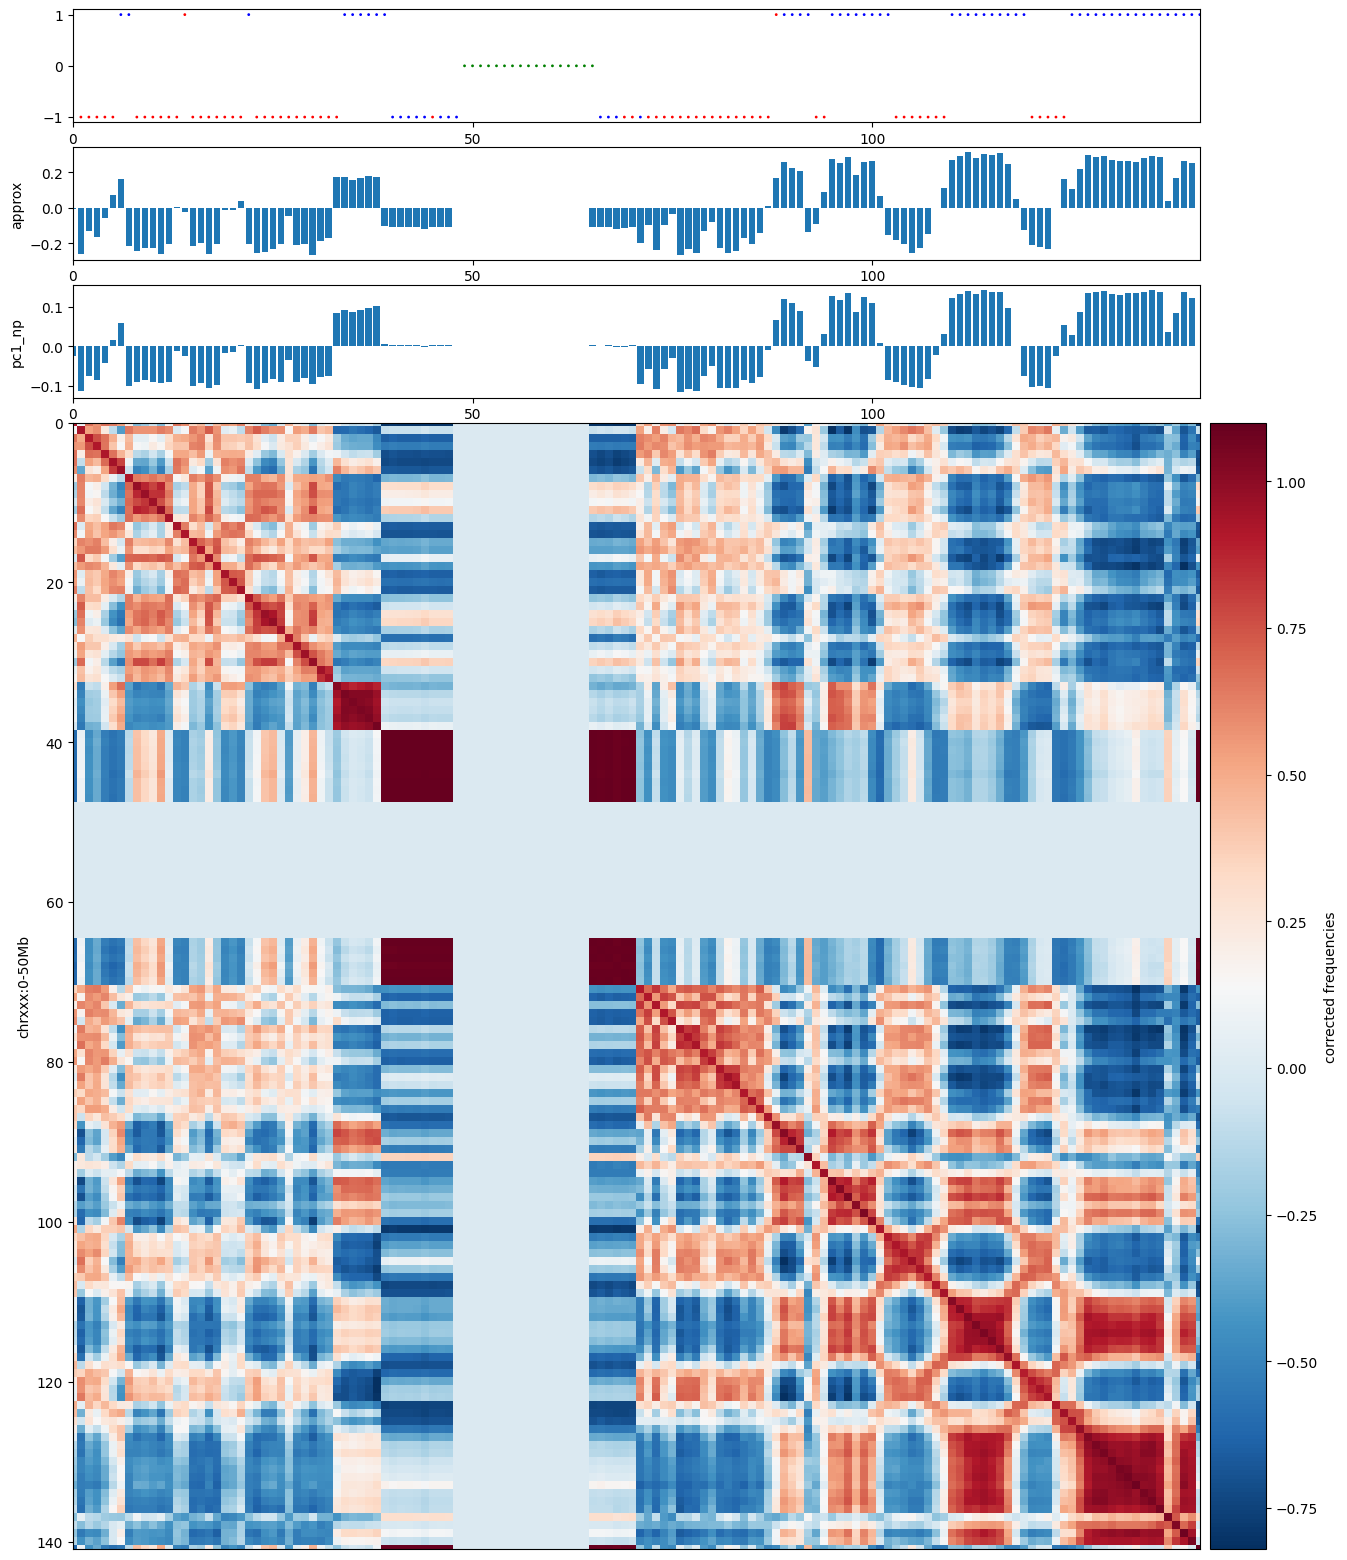

In [6]:
f, ax = plt.subplots(
    # figsize=(15, 10),
    figsize=(20, 20),
)

im = ax.matshow(
    pearson_np,
    cmap='RdBu_r',
)
plt.axis([0,len(approx_np),len(approx_np),0])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax, label='corrected frequencies')
ax.set_ylabel('chrxxx:0-50Mb')
ax.xaxis.set_visible(False)

#### pc1
ax1 = divider.append_axes("top", size="10%", pad=0.25, sharex=ax)
x = [i for i in range(0, len(pc1_np))]
ax1.bar(x, pc1_np)
ax1.set_ylabel('pc1_np')
ax1.set_xticks([])

#### approx
ax2 = divider.append_axes("top", size="10%", pad=0.25, sharex=ax)
x = [i for i in range(0, len(approx_np))]
ax2.bar(x, approx_np)
ax2.set_ylabel('approx')
ax2.set_xticks([])

####
similarity_info = paptools.calc_similarity(pc1_np, approx_np)
total_entry_num = similarity_info["total_entry_num"]
print(similarity_info)
plot_x_axis = [i + 1 for i in range(total_entry_num)]
approx_dots = [1 if i > 0 else -1 if i < 0 else 0 for i in approx_np]
pc1_colors_values = [2 if i > 0 else 0 if i < 0 else 1 for i in pc1_np]
pc1_colors = ListedColormap(['r', 'g', 'b'])

ax3 = divider.append_axes("top", size="10%", pad=0.25, sharex=ax)
ax3.set_xticks(np.arange(0, total_entry_num, 50))
ax3.scatter(plot_x_axis, approx_dots, c=pc1_colors_values, cmap=pc1_colors, s=1)